# IMPORT LIBRARIES

In [27]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import cv2
import skimage.transform


# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

# SETTINGS

## Global

In [28]:
# Settings
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')

# toy=True - development mode, small samples, limited training, fast run
# toy=False - full data, slow learning and run
toy=False

#set size of validation set and test set in percentage
validation_size = 10
test_size = 10

# Generators Paramenters
batch_size = 32
img_size = (224,224)

## Dataset Parameters

In [29]:
# Dataset Root Path
dataset_path = "../input/covid-rx-and-gan/COVID-19_Radiography_Dataset+GAN"

dataset_path_viral = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

# Folder Paths
covid_path = dataset_path + "/COVID/images"
lungOpacity_path = dataset_path + "/Lung_Opacity/images"
normal_path = dataset_path + "/Normal/images"
viralPneumonia_path = dataset_path_viral + "/Viral Pneumonia/images"

# LABELS LOCAL Array
#labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
labels = ['COVID', 'Normal', 'Viral Pneumonia']

# DATA PREPARATION

In [30]:
# Generate Filename list
def filename_list():

    if toy :
        random.seed(100)
        filenames = random.sample(os.listdir(covid_path), 200) + random.sample(os.listdir(lungOpacity_path), 200) + random.sample(os.listdir(normal_path), 200) + random.sample(os.listdir(viralPneumonia_path), 200)
    else :
       #filenames = os.listdir(covid_path) + os.listdir(lungOpacity_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)
        filenames = os.listdir(covid_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)

    return filenames

In [31]:
def dataframe_generation(files):
    
    categories = []
    for filename in files:
        category = filename.split('-')[0]
        if category == labels[0]:
            categories.append(str(0))
        elif category == labels[1]:
            categories.append(str(1))
        elif category == labels[2]:
            categories.append(str(2))
        #elif category == labels[3]:
         #   categories.append(str(3))

    for i in range(len(files)):
        if labels[0] in files[i]:
            files[i] = os.path.join(covid_path, files[i])
        #elif labels[1] in files[i]:
            #files[i] = os.path.join(lungOpacity_path, files[i])
        elif labels[1] in files[i]:
            files[i] = os.path.join(normal_path, files[i])
        elif labels[2] in files[i]:
            files[i] = os.path.join(viralPneumonia_path, files[i])
    
    df = pd.DataFrame({
        'filename': files,
        'category': categories
    })

    return df

## Generate Dataset

In [32]:
filenames = filename_list()
dataset_df = dataframe_generation(filenames)

dataset_df.head()

,filename,category
0,../input/covid-rx-and-gan/COVID-19_Radiography...,0
1,../input/covid-rx-and-gan/COVID-19_Radiography...,0
2,../input/covid-rx-and-gan/COVID-19_Radiography...,0
3,../input/covid-rx-and-gan/COVID-19_Radiography...,0
4,../input/covid-rx-and-gan/COVID-19_Radiography...,0


In [33]:
def read_img(id):
    """
    Read image by it's id
    """
    file=id
    im=cv2.imread(file)
    return im

def draw_sample_images(dataframe, ncols, labels):

        ncols=ncols
        n_rows = len(labels)

        f, ax = plt.subplots(nrows=n_rows,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions=labels
        
        for label in range(n_rows):
            i=i+1
            samples = dataframe[dataframe["category"].astype(int) == label].filename.sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()

In [34]:
def plot_data_distribution(dataframe):
    y = np.bincount(dataframe.category)
    x = labels
    fig, ax = plt.subplots(figsize=(10,8))
    plt.bar(x, y,width=0.7)
    ax.set_xticks(x)
    ax.set_aspect('auto')
    plt.show()

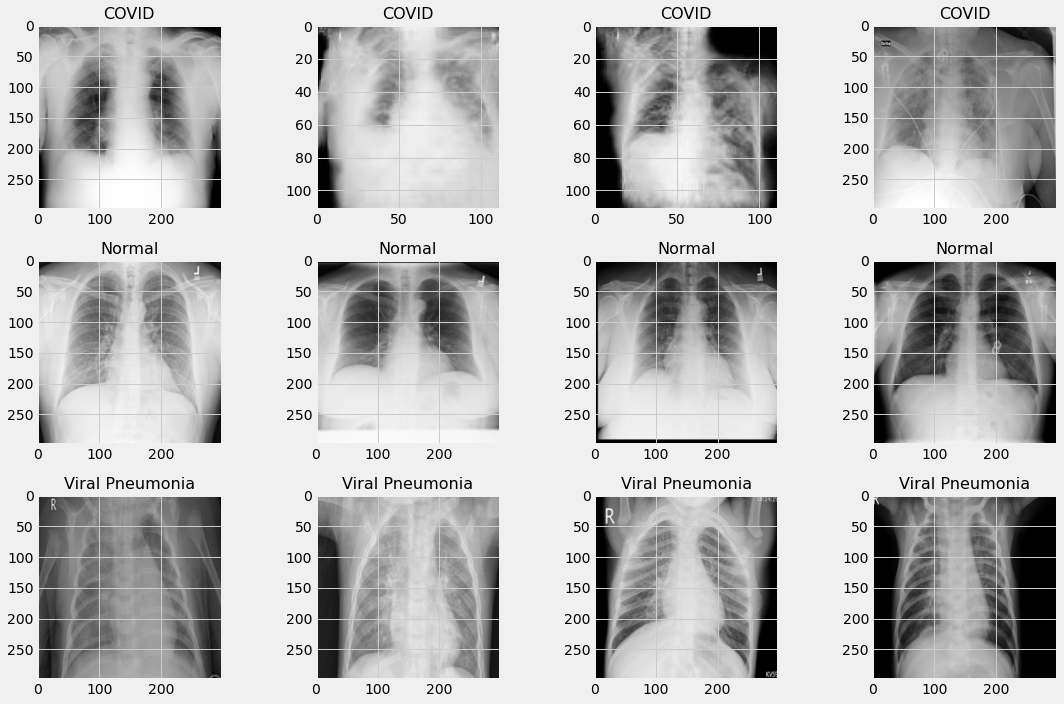

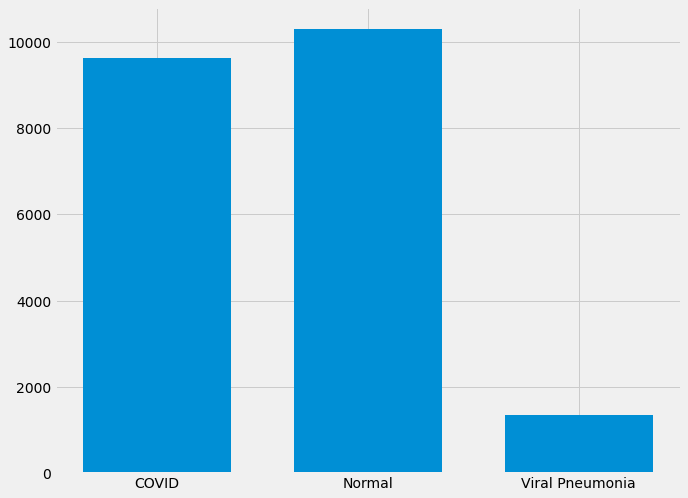

In [35]:
draw_sample_images(dataset_df, 4, labels)
plot_data_distribution(dataset_df)

## Split in Train, Validation and Test

In [36]:
def sets_split(dataframe):
    x_1_split = (validation_size + test_size)/100
    x_2_split = round(test_size / (validation_size + test_size), 2)

    train_df, valTest_df = train_test_split(dataframe, test_size=x_1_split, random_state=24)
    val_df, test_df = train_test_split(valTest_df, test_size=x_2_split, random_state=24)

    return train_df, val_df, test_df

In [37]:
train, validation, test = sets_split(dataset_df)

## Generators

In [38]:
_datagen = ImageDataGenerator(
            #rotation_range=15,
            rescale=1./255,
            #shear_range=0.1,
            #zoom_range=0.2,
            #horizontal_flip=True,
            #width_shift_range=0.1,
            #height_shift_range=0.1   
            )

_test_datagen=ImageDataGenerator(rescale=1./255)

In [39]:
train_generator = _datagen.flow_from_dataframe(
            dataframe=train,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)
print('Train generator created')

Found 17002 validated image filenames belonging to 3 classes.
Train generator created


In [40]:
val_generator = _test_datagen.flow_from_dataframe(
            dataframe=validation,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)    
print('Validation generator created')

Found 2125 validated image filenames belonging to 3 classes.
Validation generator created


In [41]:
test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test,
            x_col="filename",
            y_col=None,
            class_mode=None,
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            color_mode="rgb",
            target_size=img_size)     
print('Test generator created')

Found 2126 validated image filenames.
Test generator created


# MODEL GENERATION

## Metrics Aux Functions

In [42]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model Creation

In [43]:
def create_model(size):
        model = Sequential()

        model.add(BatchNormalization(input_shape=(224,224,3)))
        model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.35))

        model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.35))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.35))
        model.add(Dense(3, activation='softmax'))
            
        model.compile(optimizer= Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m])
        
        return model

In [44]:
model = create_model(224)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 54, 54, 32)       

## Define Trainer

In [45]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt    
import matplotlib.patches as mpatches  
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np


class AccLossPlotter(Callback):
    """Plot training Accuracy and Loss values on a Matplotlib graph. 
    The graph is updated by the 'on_epoch_end' event of the Keras Callback class
    # Arguments
        graphs: list with some or all of ('acc', 'loss')
        save_graph: Save graph as an image on Keras Callback 'on_train_end' event 
    """

    def __init__(self, graphs=['acc', 'loss'], save_graph=False):
        self.graphs = graphs
        self.num_subplots = len(graphs)
        self.save_graph = save_graph


    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.epoch_count = 0
        plt.ion()
        plt.show()


    def on_epoch_end(self, epoch, logs={}):
        self.epoch_count += 1
        self.val_acc.append(logs.get('val_accuracy'))
        self.acc.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        epochs = [x for x in range(self.epoch_count)]

        count_subplots = 0
        
        if 'acc' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Accuracy')
            #plt.axis([0,100,0,1])
            plt.plot(epochs, self.val_acc, color='r')
            plt.plot(epochs, self.acc, color='b')
            plt.ylabel('accuracy')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)

        if 'loss' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Loss')
            #plt.axis([0,100,0,5])
            plt.plot(epochs, self.val_loss, color='r')
            plt.plot(epochs, self.loss, color='b')
            plt.ylabel('loss')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)
        
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs={}):
        if self.save_graph:
            plt.savefig('training_acc_loss.png')

class ConfusionMatrixPlotter(Callback):
    """Plot the confusion matrix on a graph and update after each epoch
    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        normalize: True - normalize to [0,1], False - keep as is
        cmap: Specify matplotlib colour map
        title: Graph Title
    """
    def __init__(self, X_val, Y_val, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
        self.X_val = X_val
        self.Y_val = Y_val
        self.title = title
        self.classes = classes
        self.normalize = normalize
        self.cmap = cmap
        plt.ion()
        #plt.show()
        #plt.figure()

        plt.title(self.title)
        
        

    def on_train_begin(self, logs={}):
        pass

    
    def on_epoch_end(self, epoch, logs={}):    
        plt.clf()
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = self.Y_val
        max_y=max_y[:len(max_pred)] 
        cnf_mat = confusion_matrix(max_y, max_pred)
   
        if self.normalize:
            cnf_mat = cnf_mat.astype('float') / cnf_mat.sum(axis=1)[:, np.newaxis]

        thresh = cnf_mat.max() / 2.
        for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
            plt.text(j, i, cnf_mat[i, j],                                          
                         horizontalalignment="center",
                         color="white" if cnf_mat[i, j] > thresh else "black")

        plt.imshow(cnf_mat, interpolation='nearest', cmap=self.cmap)

        # Labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        plt.colorbar()
                                                                                                         
        plt.tight_layout()                                                    
        plt.ylabel('True label')                                              
        plt.xlabel('Predicted label')                                         
        #plt.draw()
        plt.show()
        plt.pause(0.001)

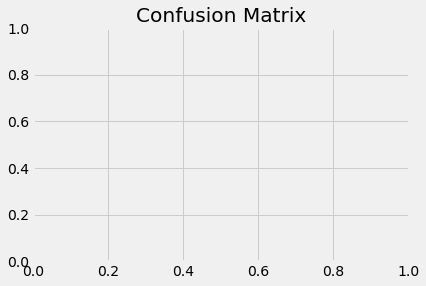

In [46]:
plotter = ConfusionMatrixPlotter(X_val=val_generator, classes=labels, Y_val=validation.category.values.astype(int))
loss_acc = AccLossPlotter()

In [47]:
def train(model, train_data, val_data, toy):
        """
        Train the model
        """
        if toy:
            epochs=3

        else:
            epochs=100
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_loss', mode='min', patience=5 , restore_best_weights=True)

        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_loss'
                                        ,mode='min'
                                        ,verbose=1
                                        ,save_best_only=True)
        # Train
        training = model.fit(train_data, 
                            validation_data = val_data, 
                            epochs = epochs, 
                            verbose = 1,
                            batch_size = batch_size,
                            callbacks=[earlystopper, checkpointer,plotter, loss_acc])
        
        print("Trained")
                            
        return training

Epoch 1/100
532/532 [==============================] - 57s 106ms/step - loss: 0.3900 - accuracy: 0.8389 - f1_m: 0.8361 - precision_m: 0.8469 - recall_m: 0.8262 - val_loss: 0.2794 - val_accuracy: 0.9049 - val_f1_m: 0.9023 - val_precision_m: 0.9209 - val_recall_m: 0.8850

Epoch 00001: val_loss improved from inf to 0.27936, saving model to best_model1.h5


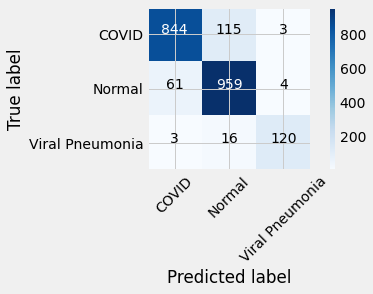

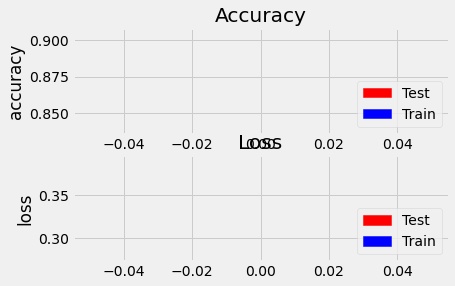

Epoch 2/100
532/532 [==============================] - 53s 99ms/step - loss: 0.2459 - accuracy: 0.9085 - f1_m: 0.9080 - precision_m: 0.9119 - recall_m: 0.9043 - val_loss: 0.2035 - val_accuracy: 0.9318 - val_f1_m: 0.9317 - val_precision_m: 0.9361 - val_recall_m: 0.9275

Epoch 00002: val_loss improved from 0.27936 to 0.20355, saving model to best_model1.h5


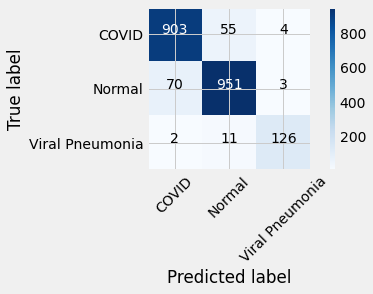

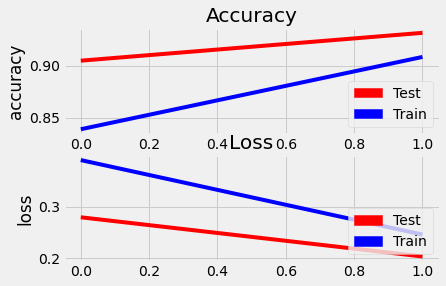

Epoch 3/100
532/532 [==============================] - 61s 114ms/step - loss: 0.2018 - accuracy: 0.9301 - f1_m: 0.9300 - precision_m: 0.9317 - recall_m: 0.9283 - val_loss: 0.1724 - val_accuracy: 0.9416 - val_f1_m: 0.9412 - val_precision_m: 0.9443 - val_recall_m: 0.9382

Epoch 00003: val_loss improved from 0.20355 to 0.17236, saving model to best_model1.h5


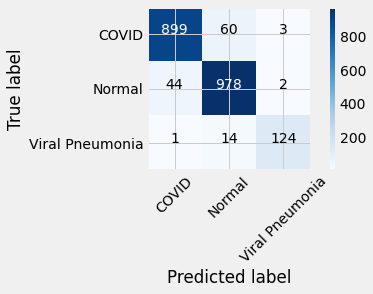

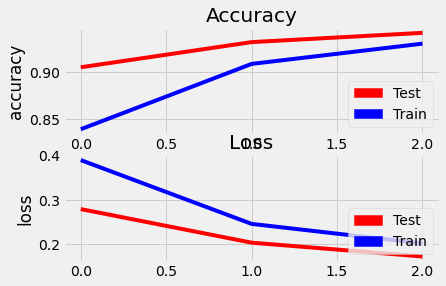

Epoch 4/100
532/532 [==============================] - 51s 96ms/step - loss: 0.1811 - accuracy: 0.9390 - f1_m: 0.9389 - precision_m: 0.9404 - recall_m: 0.9375 - val_loss: 0.1586 - val_accuracy: 0.9402 - val_f1_m: 0.9411 - val_precision_m: 0.9435 - val_recall_m: 0.9387

Epoch 00004: val_loss improved from 0.17236 to 0.15857, saving model to best_model1.h5


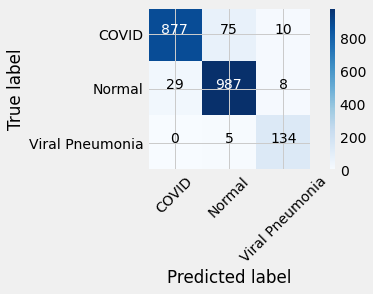

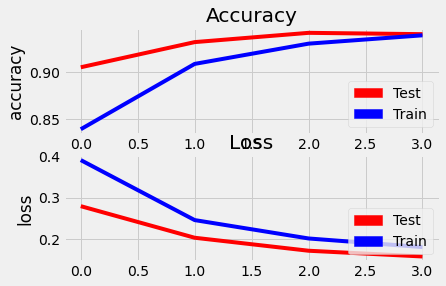

Epoch 5/100
532/532 [==============================] - 52s 98ms/step - loss: 0.1564 - accuracy: 0.9467 - f1_m: 0.9467 - precision_m: 0.9478 - recall_m: 0.9457 - val_loss: 0.1418 - val_accuracy: 0.9482 - val_f1_m: 0.9484 - val_precision_m: 0.9501 - val_recall_m: 0.9466

Epoch 00005: val_loss improved from 0.15857 to 0.14178, saving model to best_model1.h5


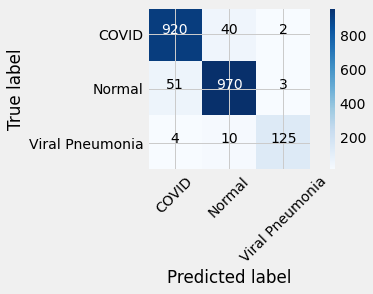

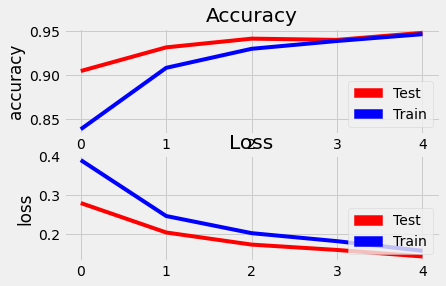

Epoch 6/100
532/532 [==============================] - 53s 99ms/step - loss: 0.1424 - accuracy: 0.9534 - f1_m: 0.9533 - precision_m: 0.9541 - recall_m: 0.9526 - val_loss: 0.1419 - val_accuracy: 0.9591 - val_f1_m: 0.9584 - val_precision_m: 0.9599 - val_recall_m: 0.9569

Epoch 00006: val_loss did not improve from 0.14178


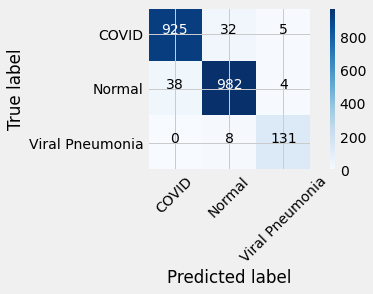

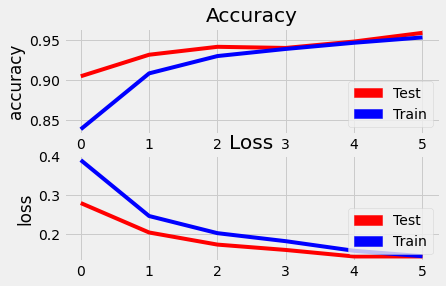

Epoch 7/100
532/532 [==============================] - 53s 100ms/step - loss: 0.1303 - accuracy: 0.9569 - f1_m: 0.9570 - precision_m: 0.9576 - recall_m: 0.9564 - val_loss: 0.1404 - val_accuracy: 0.9548 - val_f1_m: 0.9551 - val_precision_m: 0.9573 - val_recall_m: 0.9529

Epoch 00007: val_loss improved from 0.14178 to 0.14039, saving model to best_model1.h5


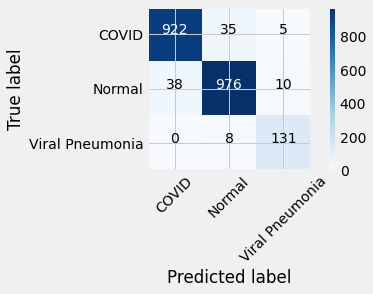

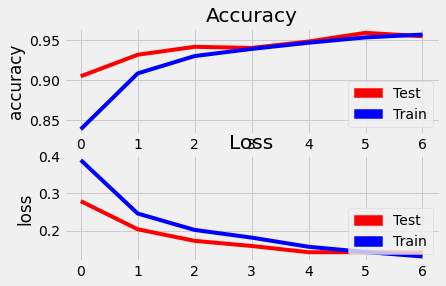

Epoch 8/100
532/532 [==============================] - 55s 103ms/step - loss: 0.1197 - accuracy: 0.9614 - f1_m: 0.9616 - precision_m: 0.9621 - recall_m: 0.9611 - val_loss: 0.1271 - val_accuracy: 0.9628 - val_f1_m: 0.9627 - val_precision_m: 0.9633 - val_recall_m: 0.9620

Epoch 00008: val_loss improved from 0.14039 to 0.12707, saving model to best_model1.h5


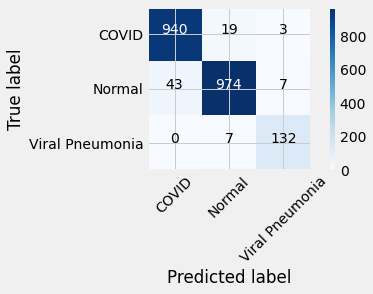

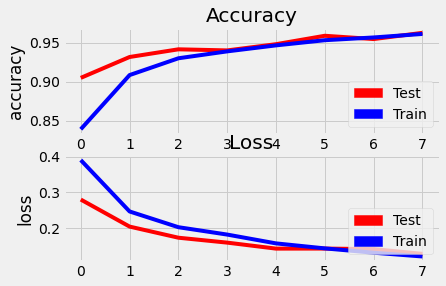

Epoch 9/100
532/532 [==============================] - 52s 98ms/step - loss: 0.1071 - accuracy: 0.9655 - f1_m: 0.9653 - precision_m: 0.9658 - recall_m: 0.9649 - val_loss: 0.1333 - val_accuracy: 0.9581 - val_f1_m: 0.9581 - val_precision_m: 0.9597 - val_recall_m: 0.9566

Epoch 00009: val_loss did not improve from 0.12707


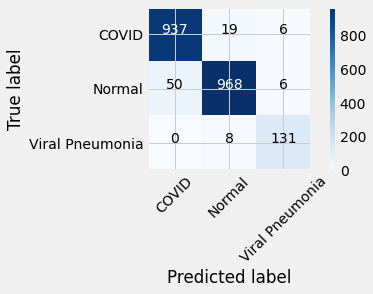

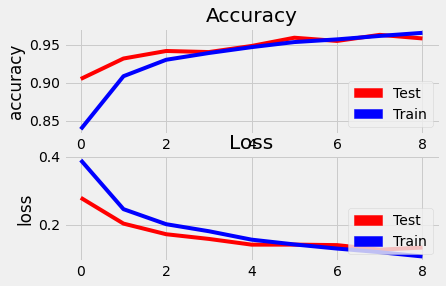

Epoch 10/100
532/532 [==============================] - 54s 101ms/step - loss: 0.1015 - accuracy: 0.9701 - f1_m: 0.9699 - precision_m: 0.9703 - recall_m: 0.9695 - val_loss: 0.1175 - val_accuracy: 0.9633 - val_f1_m: 0.9622 - val_precision_m: 0.9628 - val_recall_m: 0.9615

Epoch 00010: val_loss improved from 0.12707 to 0.11754, saving model to best_model1.h5


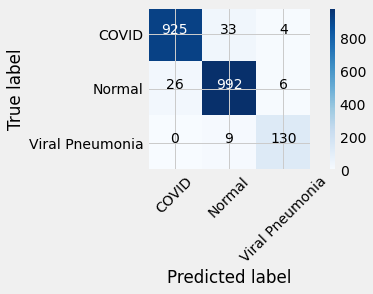

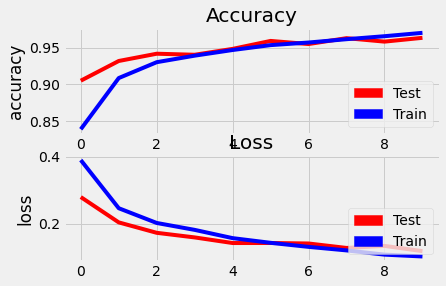

Epoch 11/100
532/532 [==============================] - 52s 98ms/step - loss: 0.0934 - accuracy: 0.9709 - f1_m: 0.9709 - precision_m: 0.9714 - recall_m: 0.9704 - val_loss: 0.1260 - val_accuracy: 0.9666 - val_f1_m: 0.9664 - val_precision_m: 0.9667 - val_recall_m: 0.9662

Epoch 00011: val_loss did not improve from 0.11754


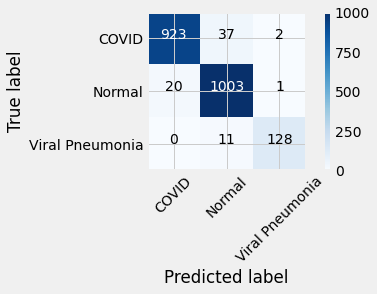

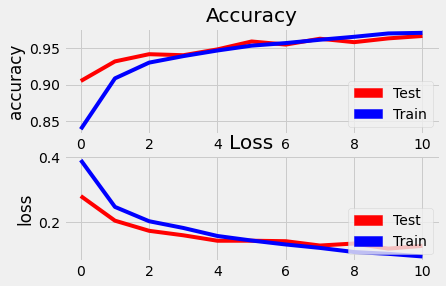

Epoch 12/100
532/532 [==============================] - 52s 98ms/step - loss: 0.0810 - accuracy: 0.9749 - f1_m: 0.9748 - precision_m: 0.9751 - recall_m: 0.9746 - val_loss: 0.1150 - val_accuracy: 0.9647 - val_f1_m: 0.9643 - val_precision_m: 0.9648 - val_recall_m: 0.9639

Epoch 00012: val_loss improved from 0.11754 to 0.11497, saving model to best_model1.h5


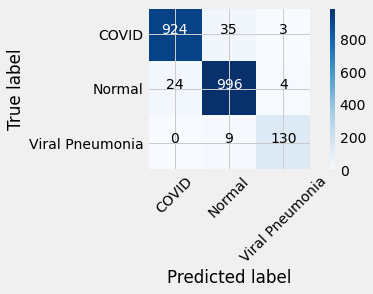

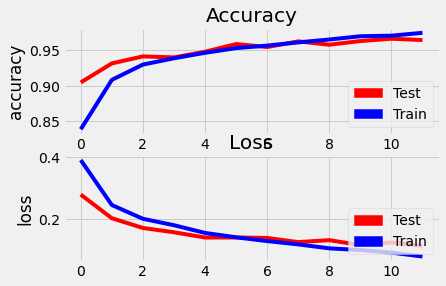

Epoch 13/100
532/532 [==============================] - 57s 106ms/step - loss: 0.0754 - accuracy: 0.9776 - f1_m: 0.9775 - precision_m: 0.9776 - recall_m: 0.9774 - val_loss: 0.1138 - val_accuracy: 0.9680 - val_f1_m: 0.9680 - val_precision_m: 0.9689 - val_recall_m: 0.9671

Epoch 00013: val_loss improved from 0.11497 to 0.11381, saving model to best_model1.h5


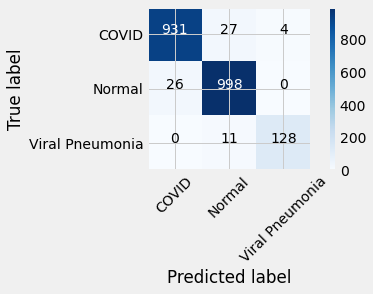

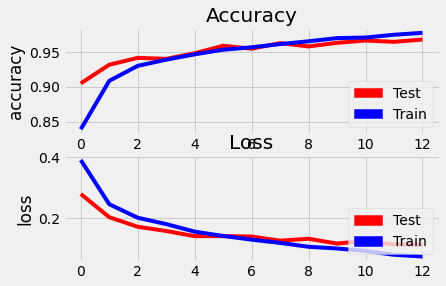

Epoch 14/100
532/532 [==============================] - 53s 99ms/step - loss: 0.0710 - accuracy: 0.9798 - f1_m: 0.9797 - precision_m: 0.9798 - recall_m: 0.9796 - val_loss: 0.1127 - val_accuracy: 0.9689 - val_f1_m: 0.9683 - val_precision_m: 0.9685 - val_recall_m: 0.9681

Epoch 00014: val_loss improved from 0.11381 to 0.11271, saving model to best_model1.h5


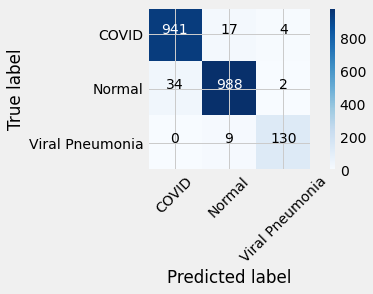

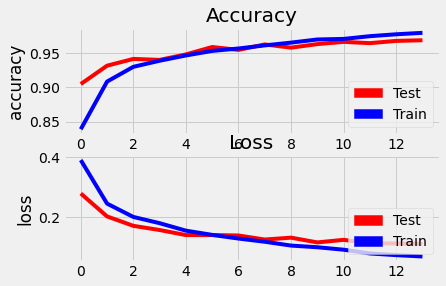

Epoch 15/100
532/532 [==============================] - 53s 99ms/step - loss: 0.0662 - accuracy: 0.9799 - f1_m: 0.9798 - precision_m: 0.9800 - recall_m: 0.9797 - val_loss: 0.1083 - val_accuracy: 0.9647 - val_f1_m: 0.9646 - val_precision_m: 0.9648 - val_recall_m: 0.9643

Epoch 00015: val_loss improved from 0.11271 to 0.10832, saving model to best_model1.h5


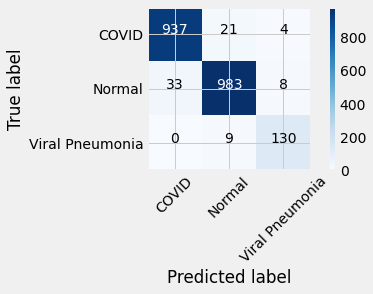

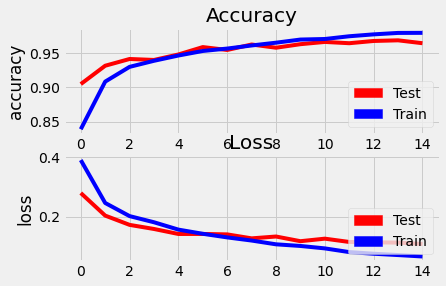

Epoch 16/100
532/532 [==============================] - 53s 99ms/step - loss: 0.0609 - accuracy: 0.9826 - f1_m: 0.9825 - precision_m: 0.9825 - recall_m: 0.9825 - val_loss: 0.1126 - val_accuracy: 0.9732 - val_f1_m: 0.9725 - val_precision_m: 0.9727 - val_recall_m: 0.9723

Epoch 00016: val_loss did not improve from 0.10832


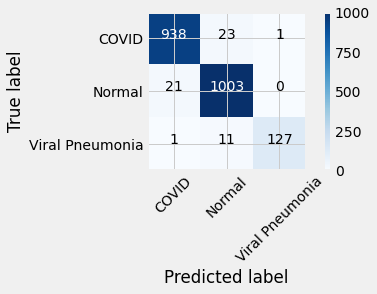

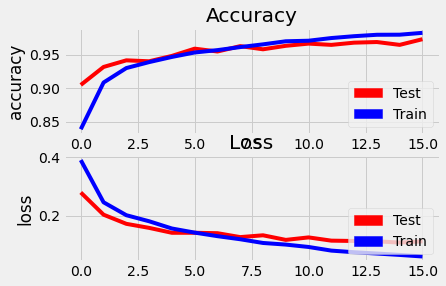

Epoch 17/100
532/532 [==============================] - 52s 98ms/step - loss: 0.0607 - accuracy: 0.9830 - f1_m: 0.9829 - precision_m: 0.9830 - recall_m: 0.9828 - val_loss: 0.1127 - val_accuracy: 0.9713 - val_f1_m: 0.9713 - val_precision_m: 0.9715 - val_recall_m: 0.9711

Epoch 00017: val_loss did not improve from 0.10832


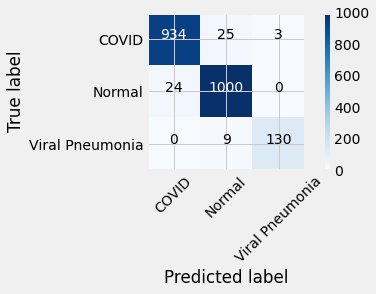

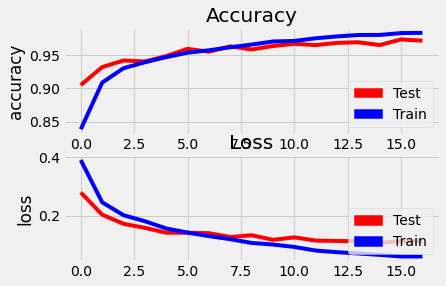

Epoch 18/100
532/532 [==============================] - 52s 98ms/step - loss: 0.0541 - accuracy: 0.9848 - f1_m: 0.9849 - precision_m: 0.9850 - recall_m: 0.9848 - val_loss: 0.1150 - val_accuracy: 0.9727 - val_f1_m: 0.9729 - val_precision_m: 0.9729 - val_recall_m: 0.9729

Epoch 00018: val_loss did not improve from 0.10832


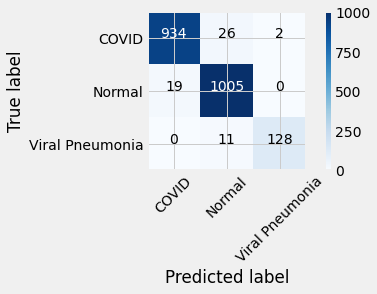

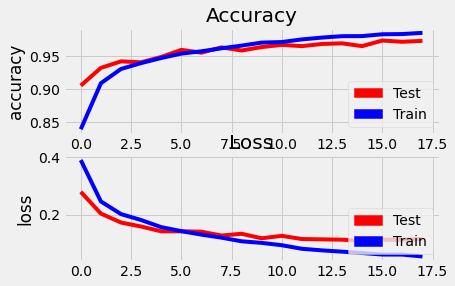

Epoch 19/100
532/532 [==============================] - 52s 97ms/step - loss: 0.0497 - accuracy: 0.9861 - f1_m: 0.9862 - precision_m: 0.9863 - recall_m: 0.9861 - val_loss: 0.1047 - val_accuracy: 0.9722 - val_f1_m: 0.9718 - val_precision_m: 0.9718 - val_recall_m: 0.9718

Epoch 00019: val_loss improved from 0.10832 to 0.10468, saving model to best_model1.h5


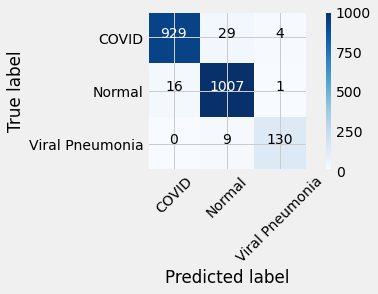

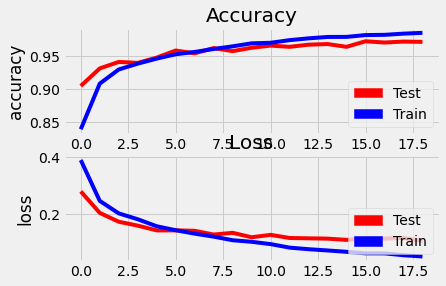

Epoch 20/100
532/532 [==============================] - 52s 99ms/step - loss: 0.0470 - accuracy: 0.9858 - f1_m: 0.9857 - precision_m: 0.9857 - recall_m: 0.9857 - val_loss: 0.1090 - val_accuracy: 0.9713 - val_f1_m: 0.9715 - val_precision_m: 0.9715 - val_recall_m: 0.9715

Epoch 00020: val_loss did not improve from 0.10468


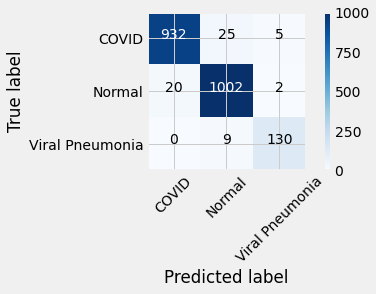

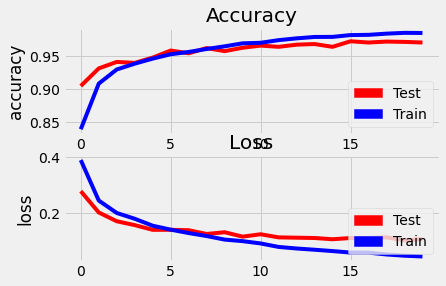

Epoch 21/100
532/532 [==============================] - 53s 99ms/step - loss: 0.0437 - accuracy: 0.9879 - f1_m: 0.9880 - precision_m: 0.9880 - recall_m: 0.9879 - val_loss: 0.1069 - val_accuracy: 0.9760 - val_f1_m: 0.9755 - val_precision_m: 0.9755 - val_recall_m: 0.9755

Epoch 00021: val_loss did not improve from 0.10468


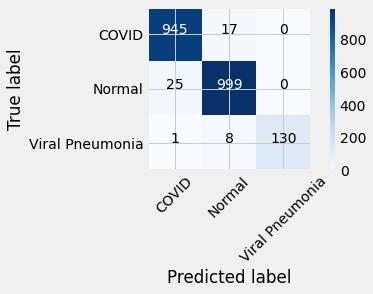

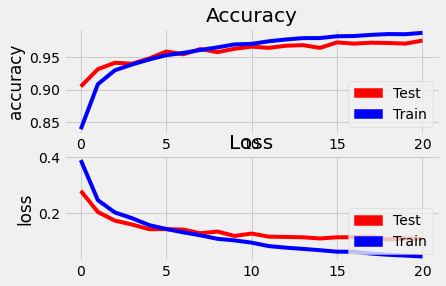

Epoch 22/100
532/532 [==============================] - 53s 99ms/step - loss: 0.0426 - accuracy: 0.9878 - f1_m: 0.9878 - precision_m: 0.9878 - recall_m: 0.9878 - val_loss: 0.1199 - val_accuracy: 0.9699 - val_f1_m: 0.9695 - val_precision_m: 0.9695 - val_recall_m: 0.9695

Epoch 00022: val_loss did not improve from 0.10468


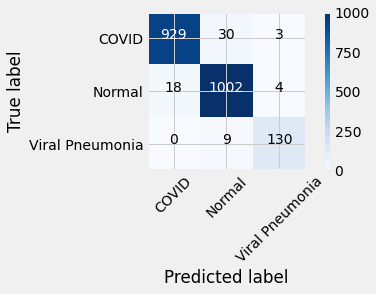

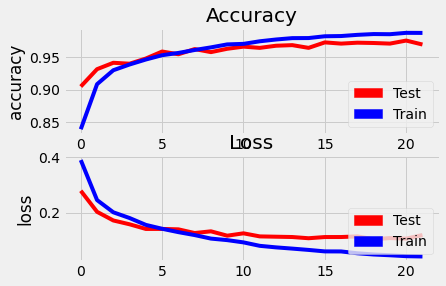

Epoch 23/100
532/532 [==============================] - 52s 97ms/step - loss: 0.0406 - accuracy: 0.9882 - f1_m: 0.9882 - precision_m: 0.9883 - recall_m: 0.9882 - val_loss: 0.1089 - val_accuracy: 0.9722 - val_f1_m: 0.9725 - val_precision_m: 0.9725 - val_recall_m: 0.9725

Epoch 00023: val_loss did not improve from 0.10468


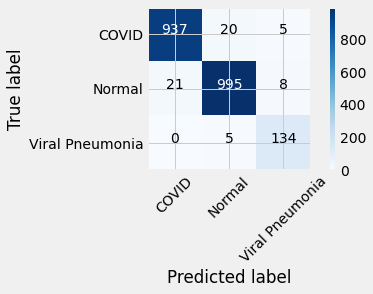

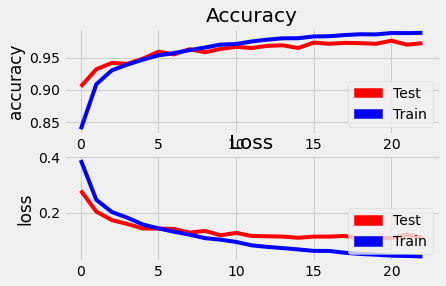

Epoch 24/100
532/532 [==============================] - 52s 98ms/step - loss: 0.0399 - accuracy: 0.9886 - f1_m: 0.9886 - precision_m: 0.9887 - recall_m: 0.9886 - val_loss: 0.1144 - val_accuracy: 0.9736 - val_f1_m: 0.9739 - val_precision_m: 0.9739 - val_recall_m: 0.9739

Epoch 00024: val_loss did not improve from 0.10468


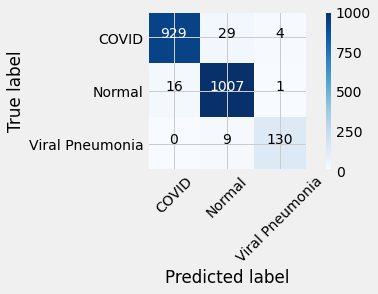

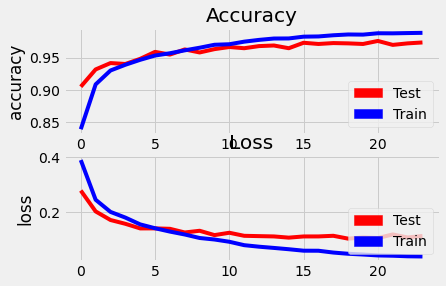

Trained


In [48]:
trained = train(model, train_generator, val_generator, toy)

# MODEL EVALUATION

## Generate Predictions

In [49]:
y_pred_raw = model.predict(test_generator)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = test.category.values
y_true=y_true[:len(y_pred)]

## Metrics Plot Functions

In [50]:
def plot_history(training):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].plot(training.history['loss'], label="Loss")
        ax[0].plot(training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(training.history['accuracy'], label="Accuracy")
        ax[1].plot(training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()

def train_report(training):
    print("------- Training Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['recall_m'])*100))
    print("Loss: %0.2f" % (np.mean(training.history['loss'])))

    print("------- Validation Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['val_accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['val_f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['val_precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['val_recall_m'])*100))
    print("Loss: %0.2f" % (np.mean(training.history['val_loss'])))

def print_report():
    """
    Predict and evaluate using ground truth from labels
    Test generator did not shuffle 
    and we can use true labels for comparison
    """
    #Print classification report
    print(metrics.classification_report(y_true, y_pred.astype(str), target_names = labels))
    
def print_conf_mtx():
    
    cm = confusion_matrix(y_true.astype(int), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

## Results

------- Training Report -----------
Accuracy: 96.37
F1 Score: 96.35
Precision: 96.45
Recall: 96.26
Loss: 0.11
------- Validation Report -----------
Accuracy: 96.04
F1 Score: 96.02
Precision: 96.18
Recall: 95.86
Loss: 0.13


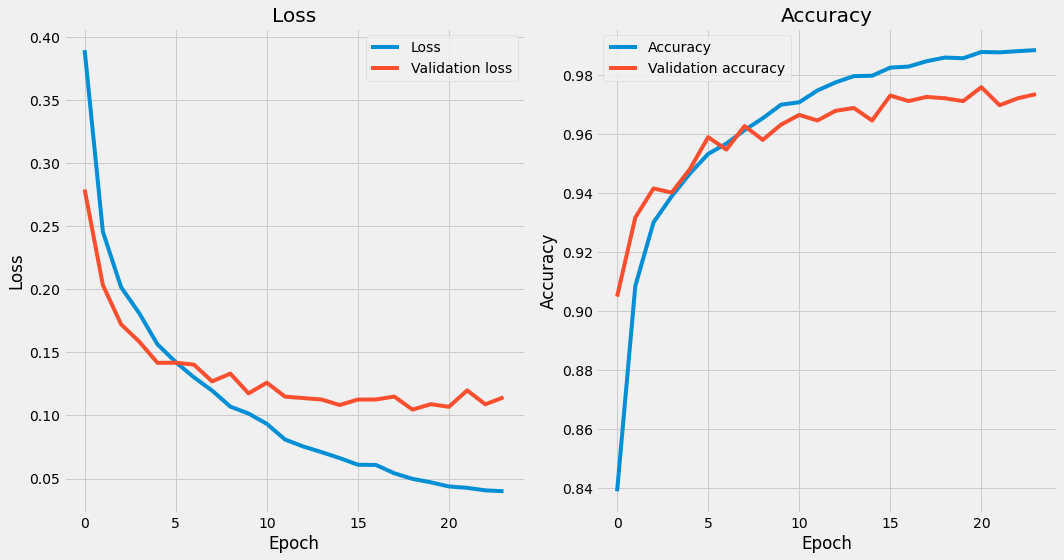

                 precision    recall  f1-score   support

          COVID       0.97      0.97      0.97       967
         Normal       0.97      0.97      0.97      1023
Viral Pneumonia       0.97      0.96      0.97       136

       accuracy                           0.97      2126
      macro avg       0.97      0.97      0.97      2126
   weighted avg       0.97      0.97      0.97      2126



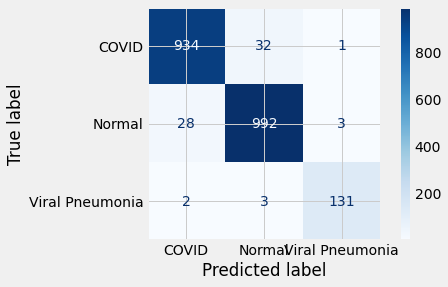

In [51]:
train_report(trained)
plot_history(trained)
print_report()
print_conf_mtx()